# Morpheus

In this notebook we show how to interface pyABC with the [Morpheus](https://morpheus.gitlab.io/) toolbox.

In [1]:
import pyabc
import pyabc.external
import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


A Morpheus model is created by passing a Morpheus XML file to the ``pyabc.external.MorpheusModel`` class.

In [2]:
file_ = "/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml"
model = pyabc.external.MorpheusModel(file_, output=pyabc.external.morpheus.output_dict)

print(model)

MorpheusModel {
	exec_name:	morpheus
	model_file:	/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml
	name:	/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml
	output:	output_dict
}


Let us generate some dummy observed data. Therefore, we sample from true parameters. The returned value contains a link to a folder which has been newly created to accommodate all simulation files. By default, that folder is in the system's temporary folders, but that can also be customized.

The paramters we define here must correspond to Constants in the Morpheus XML file.

In [3]:
true_pars = {'V1': 2.5, 'V2': 0.25, 'k3': 0.025, 'k4': 0.025}
limits = {key: (0.5 * val, 2 * val) for key, val in true_pars.items()}

# generate data
observed_data = model.sample(true_pars)

Here, we specified the output to be a dictionary object. The output format can also be customized. Let us see what we obtain:

In [4]:
print(pd.DataFrame(observed_data))

       time  cell.id      MAPK   MAPK_P    MAPK_PP      MKK     MKK_P  \
0     0.000        1  280.0000  10.0000   10.00000  280.000  10.00000   
1     0.001        1  279.8980  10.5014    9.60098  280.096  10.59510   
2     0.002        1  279.8720  10.9208    9.20762  279.883  11.28030   
3     0.003        1  279.8980  11.2760    8.82644  279.365  12.05510   
4     0.004        1  279.9520  11.5834    8.46472  278.541  12.92080   
5     0.005        1  280.0120  11.8575    8.13013  277.411  13.87920   
6     0.006        1  280.0570  12.1122    7.83045  275.972  14.93210   
7     0.007        1  280.0660  12.3608    7.57351  274.224  16.08010   
8     0.008        1  280.0170  12.6159    7.36710  272.166  17.32230   
9     0.009        1  279.8910  12.8900    7.21907  269.798  18.65620   
10    0.010        1  279.6670  13.1953    7.13742  267.121  20.07730   
11    0.011        1  279.3260  13.5433    7.13046  264.139  21.57910   
12    0.012        1  278.8480  13.9452    7.20693 

As usual, we have to define a prior for our parameters. Also, we have to define a distance which computes a 1-dim value from the generated data. Note that also this step can be customized, e.g. for arbitrary summary statistics.

In [5]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

def distance(val1, val2):
    d = np.sum([np.sum(np.abs(val1[key] - val2[key])) \
                for key in ['MAPK_P', 'MKK_P']])
    return d

Now, we are able to run our ABC analysis as usual. The ``pyabc.external`` classes take care of all calls to the external simulator.

In [6]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, observed_data)

INFO:History:Start <ABCSMC(id=5, start_time=2019-06-19 10:59:16.263269, end_time=None)>


In [7]:
abc.run(max_nr_populations=8)

INFO:Epsilon:initial epsilon is 60729.70741000001
INFO:ABC:t:0 eps:60729.70741000001
INFO:ABC:t:1 eps:38203.4655675
INFO:ABC:t:2 eps:26864.854246570314
INFO:ABC:t:3 eps:22503.846638769635
INFO:ABC:t:4 eps:16418.9679856213
INFO:ABC:t:5 eps:10088.350816096287
INFO:ABC:t:6 eps:8535.57451213258
INFO:ABC:t:7 eps:6546.812206877467
INFO:History:Done <ABCSMC(id=5, start_time=2019-06-19 10:59:16.263269, end_time=2019-06-19 11:08:02.242473)>


We can also plot some results to see what ABC did.

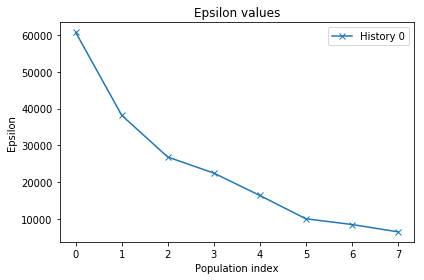

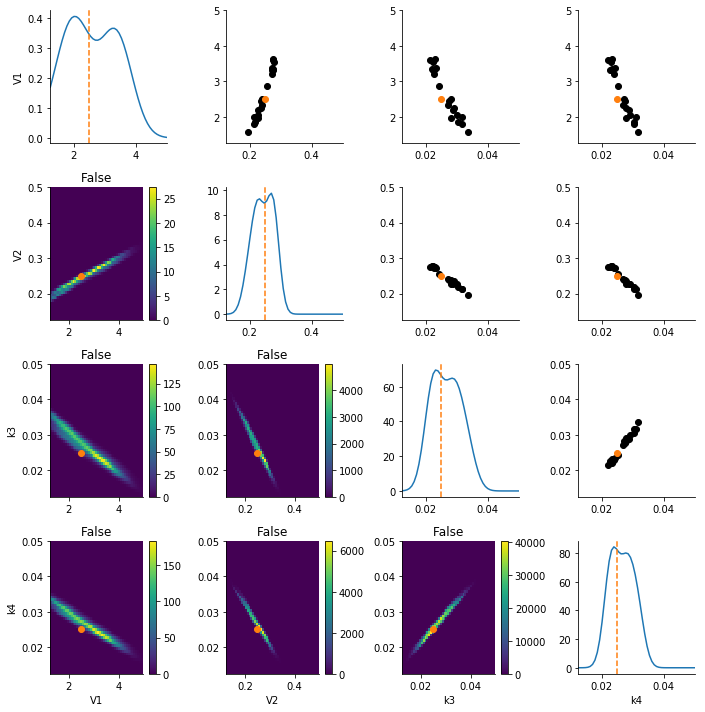

In [8]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()